In [1]:
from spatial_lstm import SpatialLSTM
from flax import nnx
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax

# Dataset

In [2]:
import os

# downloaded from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
dataset_path = '/home/apoorv/Projects/datasets/cifar-10-batches-py/'

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar10_batches = []
for i in range(1, 6):
    file_path = os.path.join(dataset_path, f'data_batch_{i}')
    batch = unpickle(file_path)
    cifar10_batches.append(batch)

In [3]:
def get_training_image(cifar10_batches):
    train_images = []
    train_labels = []
    for batch in cifar10_batches:
        images = batch[b'data']
        images = images.reshape(images.shape[0], 3, 32, 32)
        train_images.append(images)
        train_labels.append(batch[b'labels'])
    train_images = np.row_stack(train_images)
    return train_images

In [4]:
train_images = get_training_image(cifar10_batches)
train_images_bw = np.einsum('bchw,c->bhw', train_images, np.array([0.3, 0.59, 0.11]))

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def display_image_grid(images, grid_shape):
    assert images.shape[0] == grid_shape[0] * grid_shape[1]
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=grid_shape)
    fig.patch.set_facecolor('black') # Set background to black for better contrast
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, ax in enumerate(axes.flat):
        img_to_show = images[i]
        ax.imshow(img_to_show, cmap='gray')
        ax.axis('off') # Hide the x and y axes
    plt.show()

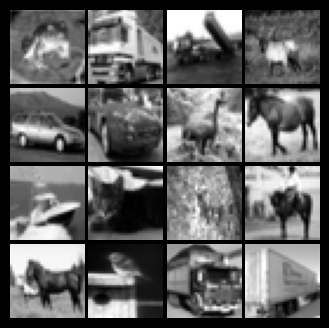

In [6]:
display_image_grid(train_images_bw[:16], (4, 4))

/home/apoorv/anaconda3/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


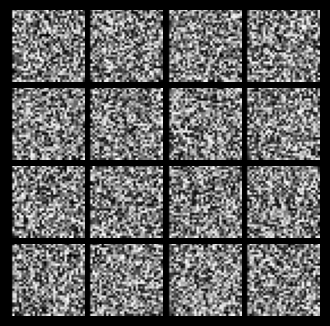

In [7]:
rngs = nnx.Rngs(params=0)
model = SpatialLSTM(500, rngs)
b = 16
key = jnp.zeros((b, 2))
gen_image_batch = model.generate(32, 32, b, jax.random.key(0))

display_image_grid(gen_image_batch, (4, 4))

In [8]:
class Batcher:
    def __init__(self, images, batch_size):
        self.images = images
        self.bsz = batch_size
        self.iter = 0
    
    def get_batch(self):
        if (self.iter + 1) * self.bsz < self.images.shape[0]:
            start_idx = self.iter * self.bsz
            end_idx = (self.iter + 1) * self.bsz
            self.iter += 1
            return self._preprocess_batch(self.images[start_idx: end_idx])
        else:
            self.shuffle()
            return self.get_batch()
        
    def l_pad(self, image_batch):
        padding_config = ((0, 0), (0, 0), (1, 0))
        image_batch = np.pad(image_batch, padding_config, mode='constant', constant_values=0)
        return image_batch
        
    def _preprocess_batch(self, image_batch):
        image_batch = image_batch.astype(np.uint8)
        image_batch = self.l_pad(image_batch)
        return nnx.one_hot(image_batch, 256)
    
    def shuffle(self):
        self.images = np.random.shuffle(self.images)
        self.iter = 0

# Model

In [9]:
# @nnx.jit
def compute_loss(model, image_batch):
    labels = image_batch[:, :, 1:]
    logits = model(image_batch)[:, :, :-1]

    loss = optax.softmax_cross_entropy(logits, labels, axis=-1)
    loss = jnp.mean(jnp.mean(loss, axis=[1, 2]))
    loss = jnp.mean(loss)
    return loss

@nnx.jit
def train_step(model, optimizer, batch):
    grad_fn = nnx.value_and_grad(compute_loss)
    loss, grads = grad_fn(model, batch)
    optimizer.update(grads)
    return loss

## Overfit model to one image

loss[0]: 5.5764570236206055
loss[1]: 5.450227737426758
loss[2]: 5.224337100982666
loss[3]: 5.064576148986816
loss[4]: 4.967633247375488
loss[5]: 4.825272560119629
loss[6]: 4.706384181976318
loss[7]: 4.600107192993164
loss[8]: 4.503174781799316
loss[9]: 4.411497116088867
loss[10]: 4.366074562072754
loss[11]: 4.407724380493164
loss[12]: 4.197610855102539
loss[13]: 4.265087604522705
loss[14]: 4.102231502532959
loss[15]: 4.102790355682373
loss[16]: 3.9803903102874756
loss[17]: 3.941174268722534
loss[18]: 3.855062484741211
loss[19]: 3.8027310371398926
loss[20]: 3.761117696762085
loss[21]: 3.659719944000244
loss[22]: 3.637568473815918
loss[23]: 3.5577597618103027
loss[24]: 3.503481864929199
loss[25]: 3.459998607635498
loss[26]: 3.4065513610839844
loss[27]: 3.44429349899292
loss[28]: 3.3402132987976074
loss[29]: 3.3086485862731934
loss[30]: 3.196659564971924
loss[31]: 3.147250175476074
loss[32]: 3.144913673400879
loss[33]: 3.1019515991210938
loss[34]: 3.1063008308410645
loss[35]: 2.9456362724

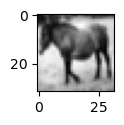

In [10]:
### overfit to one image

image = train_images_bw[7].astype(np.uint8)
plt.figure(figsize=(1, 1))
plt.imshow(image, cmap='gray')

batcher = Batcher(train_images_bw, 1)
batch = image[jnp.newaxis, ...]
batch_proc = batcher._preprocess_batch(batch)

batch_proc.shape

rngs = nnx.Rngs(params=0)
model = SpatialLSTM(500, rngs)
optimizer = nnx.Optimizer(model, optax.adam(
    learning_rate=1e-2,
))

for i in range(500):
    loss = train_step(model, optimizer, batch_proc)
    print(f"loss[{i}]: {loss}")

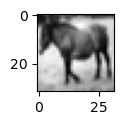

In [11]:
b = 1
key = jnp.zeros((b, 2))
gen_image_batch = model.generate(32, 32, b, jax.random.key(3))

gen_image_batch.shape
plt.figure(figsize=(1, 1))
plt.imshow(gen_image_batch[0][:,1:], cmap='gray')

## Train Model on full CIFAR-10 data

In [17]:
rngs = nnx.Rngs(params=0)
model = SpatialLSTM(100, rngs)
warmup_steps = 50
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=1e-4,
    peak_value=1e-2,
    warmup_steps=warmup_steps,
    decay_steps=1000
)
optimizer = nnx.Optimizer(model, optax.adam(lr_scheduler))

In [18]:
def count_params(model):
    params = nnx.state(model, nnx.Param)
    total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(params))
    print(total_params)

    for path, x in jax.tree_util.tree_leaves_with_path(params):
        print(path, np.prod(x.shape))

count_params(model)

254656
(DictKey(key='h_init'), GetAttrKey(name='value')) 100
(DictKey(key='head'), DictKey(key='bias'), GetAttrKey(name='value')) 256
(DictKey(key='head'), DictKey(key='kernel'), GetAttrKey(name='value')) 25600
(DictKey(key='lstm'), DictKey(key='gate'), DictKey(key='bias'), GetAttrKey(name='value')) 500
(DictKey(key='lstm'), DictKey(key='gate'), DictKey(key='kernel'), GetAttrKey(name='value')) 228000
(DictKey(key='lstm'), DictKey(key='ln'), DictKey(key='bias'), GetAttrKey(name='value')) 100
(DictKey(key='lstm'), DictKey(key='ln'), DictKey(key='scale'), GetAttrKey(name='value')) 100


In [19]:
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
batch_size = 256
train_total_steps = 50000 // batch_size
num_epochs = 10
import tqdm


train_metrics_history = {
    "train_loss": [],
}

def train_one_epoch(epoch, model, optimizer):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        batcher = Batcher(train_images_bw, batch_size)
        for i in range(train_total_steps):
            batch = batcher.get_batch()
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)

In [ ]:
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, optimizer)

[train] epoch: 0/10, [0/195] [00:00<?]

In [ ]:
gen_image_batch = model.generate(32, 32, 1, jax.random.key(123))
plt.figure(figsize=(1, 1))
plt.imshow(gen_image_batch[0][:,1:], cmap='gray')